In [214]:
#imports
from time import time
import numpy as np
import pandas as pd
from scipy import signal
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
from numpy import pi, sin, cos, tan, abs
import sklearn
from sklearn.cross_decomposition import CCA
from numpy.linalg import inv, eig
import seaborn as sns

In [215]:
# Functions
def custom_filter_band(data, lf, hf, fs, type):
    """
    Applies a bandpass filter to the signal 
    Args:
        data: EEG signal with the shape: (N_chan, N_sample)
        lf: Low cutoff frequency
        hf: High cutoff frequency
        fs: Sampling rate
        type: Filter type, 'bandstop' or 'bandpass'
    Returns:
        (numpy ndarray): Filtered signal (N_chan, N_sample)
    """
    N = 5
    b, a = signal.butter(N, [lf / (fs/2), hf / (fs/2)], type)
    return signal.filtfilt(b, a, data)


def extract_epochs(sig, sig_times, event_times, t_min, t_max, fs):
    """ Extracts epochs from signal
    Args:
        sig: EEG signal with the shape: (N_chan, N_sample)
        sig_times: Timestamp of the EEG samples with the shape (N_sample)
        event_times: Event marker times
        t_min: Starting time of the epoch relative to the event time
        t_max: End time of the epoch relative to the event time
        fs: Sampling rate
    Returns: a list of epochs and the time signature of each epoch
    """
    offset_st = int(t_min * fs)
    offset_end = int(t_max * fs)
    epoch_list = []
    for i, event_t in enumerate(event_times):
        idx = np.argmax(sig_times >= event_t)
        epoch_list.append(sig[:, idx + offset_st:idx + offset_end])
    ts_epoch = sig_times[idx + offset_st:idx + offset_end]
    ts_epoch = ts_epoch - ts_epoch[0]
    return np.array(epoch_list), ts_epoch

def extract_epochs_wo_markers(sig, t_min, t_max, fs):
    epoch_list = []
    epoch_length_samples = (t_max - t_min) * fs
    n_epochs = sig.shape[1] // epoch_length_samples

    for i in range(n_epochs):
        epoch_list.append(sig[:, i*epoch_length_samples:(i+1)*epoch_length_samples])

    # list and not numpy array
    np.random.shuffle(epoch_list)
    return np.array(epoch_list)

def create_confusion_matrix(predictions, groundtruths, gt_dict, plot=True, title = None):
    """ 
    Create confusion matrix from predictions and ground truths
    Args:
        predictions: array containing predictions with shape (# epochs)
        groundtruths: array containing ground truth labels with shape (# epochs)
        gt_dict: dictionary containing {ground truth label: corresponding frequency}
        plot: boolean, set to True to plot confusion matrix as heatmap
    Returns: array containing confusion matrix with shape (# frequencies x # frequencies)
    """
    n_freq = len(set(gt_dict.values()))
    confusion_matrix = np.zeros((n_freq,n_freq))
    frequencies = list(set(gt_dict.values()))
    groundtruth = groundtruths.copy()
    for key, value in gt_dict.items():
        groundtruth[groundtruth == key] = value
    for i in range(len(predictions)):
        x = frequencies.index(predictions[i])
        y = frequencies.index(groundtruths[i])
        confusion_matrix[y,x] += 1

    if plot == True:
        cm_df = pd.DataFrame(confusion_matrix, index = frequencies, columns = frequencies)
        ax = sns.heatmap(cm_df/sum(confusion_matrix[0]), annot=True, square=True, cmap = 'Blues', fmt= '.2f')
        ax.tick_params(length=5, labelsize=12)            
        plt.ylabel("Actual frequency [Hz]", size=15, labelpad=10)
        plt.xlabel("Predicted frequency [Hz]", size=15, labelpad=10)
        plt.tight_layout()
        if title is not None:
            plt.title(title, size = 15, pad = 10)
            plt.savefig('../'+title+'.svg', dpi=350,  bbox_inches = "tight")
        plt.show()


    return confusion_matrix



In [216]:
### data is in a folder called DATA_mentalab_13102022 in the parent directory of the directory this file is in.
### change this to where your data is.
parent = os.path.dirname(os.getcwd()) 
path = parent + "\\DATA_mentalab_13102022\\"

fname_data4 = [
    "Nils_8Hz_ExG.csv",
    "Nils_10Hz_ExG.csv",
    "Nils_12Hz_ExG.csv",
    "Nils_0Hz_ExG.csv",
]

fnames = [fname_data4]
gt_dict = {8:8, 10:10, 12:12}
fs = 250  # Hz, sampling frequency
t_min = 0  # Start time of epoch since marker (seconds)
t_max = 4 # End time of epoch since marker (seconds)
screen_refresh_rate = 60
ch_names = ['ch4','ch6','ch7']
lf = .5    # low frequency for bandpass filtering
hf = 50  # high frequency for bandpass filtering

n_samples = (t_max-t_min)*fs
epochs = np.zeros((0,3,n_samples))
markers = []
# read in the data
for fname in fnames:
    for button in fname:
        data = pd.read_csv(path + button, delimiter=",")  # EEG data
        sig = data[ch_names].to_numpy().T  # EEG signals, channels by data samples
        b_notch, a_notch = signal.iirnotch(50, 20, fs)
        filt_sig = signal.filtfilt(b_notch, a_notch, sig)
        filt_sig = custom_filter_band(filt_sig, lf, hf, fs, 'bandpass')
        epoch = extract_epochs_wo_markers(filt_sig, t_min, t_max, fs)
        epochs = np.vstack((epochs, epoch))
        ind = button.index('Hz')
        if ind-2 < 0:
            freq = 0
        else:
            freq = button[ind-2:ind]
            if freq[0] == '_':
                freq = freq[1]
        freq = int(freq)
        markers += [freq]*int((60/(t_max-t_min)))


________
[0.16305364 0.08455429 0.09132881] True certain enough
[0.15188421 0.08045959 0.06319457] True certain enough
[0.21375034 0.07550606 0.09180523] True certain enough
[0.13133524 0.07696376 0.08926189] True certain enough
[0.11973    0.08705309 0.07236094] True certain enough
[0.10085374 0.0936549  0.04829174] True difference too small
[0.11984735 0.07421442 0.10160588] True difference too small
[0.14767757 0.07007471 0.05769303] True certain enough
[0.19241696 0.09107541 0.11780057] True certain enough
[0.193545  0.1461572 0.0829624] True certain enough
[0.05910744 0.08628305 0.06436778] False correlation too small
[0.11800713 0.05176135 0.11116334] True difference too small
[0.14183521 0.09584457 0.09752913] True certain enough
[0.18668664 0.11612319 0.09427667] True certain enough
[0.21501081 0.08713028 0.10650102] True certain enough
________
[0.08999404 0.12110858 0.05285971] True certain enough
[0.09222217 0.14277987 0.07505107] True certain enough
[0.1137373  0.0986306  0

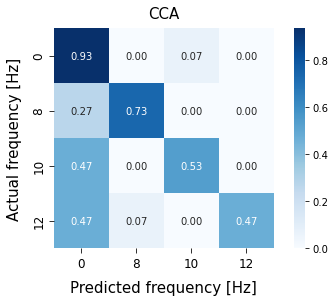

array([[14.,  0.,  1.,  0.],
       [ 4., 11.,  0.,  0.],
       [ 7.,  0.,  8.,  0.],
       [ 7.,  1.,  0.,  7.]])

In [217]:
sys.path.insert(0, '../') # find extended_CCA module
from extended_CCA import Classifier
freqs = list(gt_dict.values())
cca = Classifier(freqs, 3, t_min, t_max, 250, n_harm = 3)
# cca.classify_multiple_regular(epochs, markers)
amount_correct = 0
amount_total = 0
predictions = np.zeros(np.shape(epochs)[0])
for i in range(np.shape(epochs)[0]):
    scores = cca.classify_single_regular(epochs[i,:,:], return_scores = True)
    if i%(60/t_max-t_min) == 0:
        print('________')
    pred = cca.freqs[np.argmax(scores)]
    scores_sorted = scores.copy()
    scores_sorted.sort()

    if scores_sorted[-1] >= 1.3*scores_sorted[-2] and scores_sorted[-1] >= 0.1:
        classify = "certain enough"
        amount_total += 1
        if markers[i] == pred:
            amount_correct += 1
    elif not scores_sorted[-1] >= 1.3*scores_sorted[-2]:
        classify = "difference too small"
        pred = 0
    else:
        classify = "correlation too small"
        pred = 0
    predictions[i] = pred
    print(scores, markers[i] == cca.freqs[np.argmax(scores)], classify)

create_confusion_matrix(predictions, markers, {0:0, 8:8, 10:10, 12:12}, plot=True, title='CCA')
